In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import json

In [7]:
!python offline_data_dump.py

In [8]:
info = pd.read_csv("data/info.csv")
info.drop(["property2", "property3", "property4", "property5", ], axis=1, inplace=True)
info.rename(columns={"property1": "chosen"}, inplace=True)
info["chosen"].fillna(False, inplace=True)

info.head()

,id,creation_time,chosen,failed,time_of_death,type,origin_id,network_id,contents
0,1,2017-04-06 22:44:17.295558,False,f,NaN,vector_info,1,1,"[{""category"": ""woman"", ""lock"": true, ""seed"": 0..."
1,3,2017-04-06 22:44:17.47222,False,f,NaN,vector_info,2,1,"[{""category"": ""woman"", ""lock"": false, ""seed"": ..."
2,2,2017-04-06 22:44:17.465681,True,f,NaN,vector_info,2,1,"[{""category"": ""woman"", ""lock"": false, ""seed"": ..."
3,5,2017-04-06 22:44:27.59092,False,f,NaN,vector_info,3,1,"[{""category"": ""woman"", ""lock"": true, ""seed"": 0..."
4,4,2017-04-06 22:44:27.589267,True,f,NaN,vector_info,3,1,"[{""category"": ""woman"", ""lock"": true, ""seed"": 0..."


In [179]:
# Only extract the chosen stimuli for the chain
chosen = np.array([json.loads(c) for c in info[info["chosen"]]["contents"]])
seeds = [c["seed"] for c in chosen[0]]
chains = [np.array([c["latent"] for c in chosen[:,s] if not c["lock"]]) for s in seeds]
categories = [[c["category"] for c in chosen[:,s] if not c["lock"]][0] for s in seeds]

for s in range(4):
    print chains[s].shape, categories[s]

(8, 100) woman
(11, 100) man
(7, 100) man
(6, 100) woman


In [44]:
# Apply PCA on chain for dimensionality reduction
pca = PCA(n_components=2, svd_solver='full')
pca.fit(np.vstack(chains))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

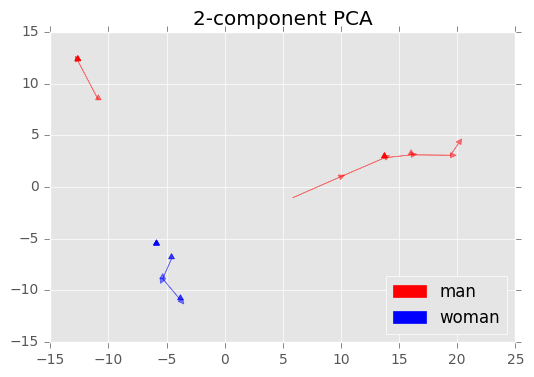

In [157]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
mpl.style.use('ggplot')
%matplotlib inline

cnames = colors.cnames.values()
plt.title('2-component PCA')
plt.xlim(-15, 25)
plt.ylim(-15, 15)
cmap = {'man': 'r', 'woman': 'b'}

for i in range(len(chains)):
    chain = pca.transform(chains[i])
    color = cmap[categories[i]]
    n, d = chain.shape
    for j in range(n-1):
        x, y = chain[j]
        dx, dy = chain[j+1] - chain[j]
        plt.arrow(x, y, dx, dy,
                 head_width=0.5,
                 head_length=0.5,
                 alpha=0.5,
                 color=color)
        
red_patch = mpatches.Patch(color='red', label='man')
blue_patch = mpatches.Patch(color='blue', label='woman')
plt.legend(handles=[red_patch, blue_patch], loc=4)
plt.show()